# Mach-Zehnder Interferometer

An interferometer is just an instrument that utilizes the interference between two beams of light to make precise measurements.

The Mach-Zehnder Interferometer (MZI) splits a light beam, sends the light down two different paths and recombines the light. We say that the MZI is balanced if the two paths are the same distance or unblanced if the path lengths differ.

![Image of an MZI](https://raw.githubusercontent.com/BYUCamachoLab/Photonics-Bootcamp/main/book/images/Notebook_Images/mzi_outline_ports_marked.webp)

One implementation of this concept is illustrated above. Notice that the inner path of the MZI is shorter than the outer path, therefore the MZI is unbalanced. This implies that the two light beams will be out of phase with each other when they are recombined and interference occurs.

Since the interference that occurs when the light is recombined is dependent on the the wavelength of the intitial beam of light, the amount of light that leaves the interferometer will be dependent on the initial wavelength.

# Sweeping
Imagine we shined a laser into the first grating coupler and then adjusted the wavelength over some range. We then can plot the data from the intensity of the light leaving the MZI against the wavelengths we tested. This is sometimes referred to as "sweeping."

![Image of an MZI with labels](https://raw.githubusercontent.com/BYUCamachoLab/Photonics-Bootcamp/main/book/images/Notebook_Images/plot_mzi.webp)

Click here for more information about implementing sweeps:
https://simphonyphotonics.readthedocs.io/en/stable/tutorials/mzi.html

# Analysis of a Balanced MZI

You can think of a balanced interferometer as having equal path lengths when the light separates. In ideal conditions, this means that amount of power at the output is the same as the input. 

In [1]:
import gdsfactory as gf

PDK = gf.get_generic_pdk()
PDK.activate()

c = gf.Component("my_component")
mzi = c << gf.components.mzi(delta_length=0)

c


Image(value=b'\x89PNG\r\n\x1a\n\x00\x00\x00\rIHDR\x00\x00\x03 \x00\x00\x02X\x08\x02\x00\x00\x00\x15\x14\x15\'\…

my_component: uid e7c90c94, ports [], references ['mzi_1'], 0 polygons


There are there three different relevant amplitudes:
1. The amplitude of the input light:
$$
    I_{input} = E_{input}^2
$$

2. The amplitudes of the beams after the split
$$
    E_{1} = \frac{E_{input}}{\sqrt{2}}
    E_{2} = \frac{E_{input}}{\sqrt{2}}
$$

3. The amplitude of the recombined light
$$
    E_{output} = \frac{E_{1}+E_{2}}{\sqrt{2}} = I_{input}
$$

***Note that these are not generalized equations. Instead, these describe balanced insterferometers whose branches have not undergone a phase shift.

## Quick Check
1. If the input power is .5 mW, what is the output power of the MZI described above? (a: .5mW)
2.  
3.

# Basic Definitions

It would be helpful to mathematically model the light in our waveguides. We can start to build a model by considering the equation for a plane wave.

$$    
    E = E_0 e^{i(\omega t - \beta z)}
$$
- 'E' is an electric field
- 'ω' is the optical frequency
- 't' is time
- 'β' is the propogation constant
- 'z' is the position


Propogation Constant of Light:
$$
    \beta = \frac{2 \pi n}{\lambda} 
$$
- 'n' is the index of refraction
- 'λ' is the wavelength

This describes a plane wave propogating through a medium in the z-direction. If our the first Y-branch splitter of our MZI split this wave, we could describe the resulting waves like this:

$$
E_{o1} = \frac{E_{i}}{\sqrt{2}}e^{-i\beta_{1}L_{1}-\frac{\alpha_{1}}{2}L_{1}}
$$

$$
E_{o2} = \frac{E_{i}}{\sqrt{2}}e^{-i\beta_{2}L_{2}-\frac{\alpha_{2}}{2}L_{2}}
$$

*** As the light travels through the waveguide we can imagine that it will experience some degree of loss. The 'α' term that appeared in the exponents is the loss coefficient. For convenience, the following examples will assume that α = 0, or that there is zero loss in our waveguides.

And finally the intensity of the the recombined light at the end of the MZI can be described like so:

$$
I_{output} = \frac{I_{input}}{4} \lvert E_{o1} + E_{o2} \lvert ^2 
$$

# Analysis of Imblanced MZI's

The equation below is the simplified version of the above expressions assuming no difference in the propogation constants of the two different waveguides and no loss.

$$
I_{output} = \frac{I_{input}}{2}(1 + cos(\beta \Delta L))
$$

You can install `pip install gdsfactory[full]` for better visualization


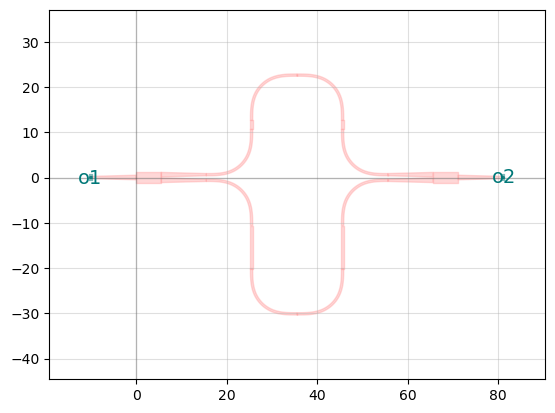

my_component: uid a71ccce9, ports [], references ['mzi_1'], 0 polygons


In [2]:
import gdsfactory as gf

PDK = gf.get_generic_pdk()
PDK.activate()

c = gf.Component("my_component")
mzi = c << gf.components.mzi(delta_length=15)

c


# Thermo-Optic Effect

Varying the path length is not the only way to unbalance a MZI. By utilizing the thermo-optic effect of silicon, we can introduce a phase shift in one of waveguides that can achieve a similar effect.

$$
I_{output} = \frac{I_{input}}{2}(1 + cos(\Delta\beta L))
$$